In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


## Load dataset

In [2]:
data_set = pd.read_csv('Crop_recommendation.csv')
print(data_set.shape)
f_title = data_set.columns

(2200, 8)


# Data preprocessing 

In [3]:
def get_mean(column):
    sum = 0
    cnt = 0
    for i in range(len(column)):
        if not pd.isnull(column[i]):
            try:
                sum += float(str(column[i]).strip())
                cnt += 1
                # print(i, column[i])
            except (ValueError, TypeError) as e:
                cnt = cnt
                # print(f"Error: {e}")
                # print(i, column[i])
    return sum / cnt        

# mean(data_set['rc'])

## Replace Numeric Empty Cell with previous value

In [4]:
def replace_numeric_empty_cell(column):
    # column = replace_non_numeric_cell(column)
    mean = get_mean(column)
    print(mean)
    col = list()
    for i in range(len(column)):
        if pd.isnull(column[i]):
            try:
                # col.append(col[-1])
                col.append(mean)
            except (ValueError, TypeError) as e:
                print(f"Error: {e}")
                col.append(0)
        else:
            try:
                col.append(float(str(column[i]).strip()))
                
            except (ValueError, TypeError) as e:
                print(f"Error: {e}")
                col.append(0)
    return col

data_set['pcv'] = replace_numeric_empty_cell(data_set['pcv'])

KeyError: 'pcv'

In [5]:
# %%capture
columns_of_numeric = ['age', 'bp', 'sg', 'al', 'su','bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc'] 
for column in columns_of_numeric:
    # print(column)
    data_set[column] = replace_numeric_empty_cell(data_set[column])
    # print('done')

KeyError: 'age'

## Replace Text data to binary and empty cell as random

In [7]:
import random
def text_to_binary(column, positive_text, negative_text):
    col = list()
    for i in range(len(column)):
        if pd.isnull(column[i]):
            col.append(random.choice([0, 1]))
        elif str(column[i]).strip() == positive_text:
            col.append(1)
        elif str(column[i]).strip() == negative_text:
            col.append(0)
        else:
            col.append(0)
    return col
    


In [8]:
%%capture
columns_of_text = [
        ['rbc', 'normal', 'abnormal'], 
        ['pc', 'normal', 'abnormal'],
        ['pcc', 'present', 'notpresent'],
        ['ba', 'present', 'notpresent'],
        ['htn', 'yes', 'no'],
        ['dm', 'yes', 'no'],
        ['cad', 'yes', 'no'],
        ['appet', 'good', 'poor'],
        ['pe', 'yes', 'no'],
        ['ane', 'yes', 'no'],
        ['classification', 'ckd', 'notckd'],]

for column_info_list in columns_of_text:
    data_set[column_info_list[0]] = text_to_binary(data_set[column_info_list[0]], column_info_list[1], column_info_list[2])

KeyError: 'rbc'

## Visualize Correlation Between Features

In [9]:
# print(f_labels)
correlation_matrix = data_set[f_title].corr()
# print(correlation_matrix)
plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("correlation_matrix")
plt.show()

ValueError: could not convert string to float: 'rice'

## Split Dependent and Independent Data

In [9]:
x = data_set.iloc[:,:-1]
y = data_set.iloc[:, -1]
print(x.shape, y.shape)

(400, 24) (400,)


# Feature Selection

## 1. Recursive Feature Elimination (RFE):

In [10]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

estimator = SVC(kernel="linear")
selector = RFE(estimator, n_features_to_select=10, step=1)  # Choose a target number of features
selector = selector.fit(x, y)

# Get the selected features
selected_features = selector.support_
x_selected = x.iloc[:, selected_features]
print(x_selected.shape)

(400, 10)


## Visualize Selected Features 

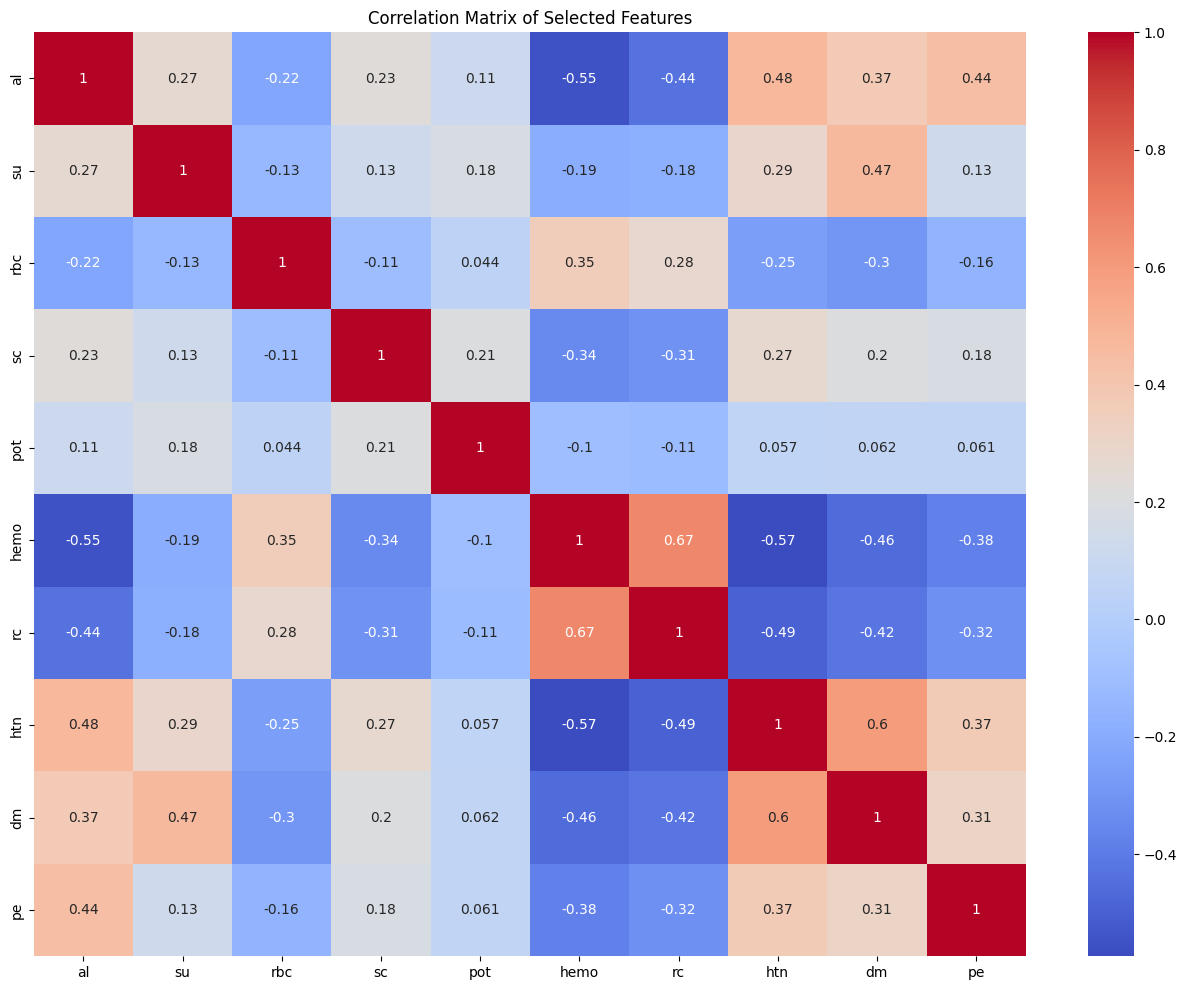

In [11]:
# print(f_labels)
correlation_matrix = x_selected.corr()
# print(correlation_matrix)
plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Selected Features")
plt.show()

## Split Train Test dataset

In [12]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)
# print(x_train)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
# print(x_train)
x_test = scaler.fit_transform(x_test)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)


(280, 24) (120, 24) (280,) (120,)


In [13]:
x_train_fs,x_test_fs,y_train_fs,y_test_fs = train_test_split(x_selected,y,test_size=0.3,random_state=42)
# print(x_train)
scaler = StandardScaler()
x_train_fs = scaler.fit_transform(x_train_fs)
# print(x_train)
x_test_fs = scaler.fit_transform(x_test_fs)
print(x_train_fs.shape,x_test_fs.shape,y_train_fs.shape,y_test_fs.shape)

(280, 10) (120, 10) (280,) (120,)


## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def logistic_regression(_x_train, _x_test, _y_train, _y_test):
    # Setting multi_class='multinomial' to use the softmax approach
    clf = LogisticRegression(random_state=42)
    
    # Train the model
    clf.fit(_x_train, _y_train)
    
    # Make predictions on the test data
    _y_pred = clf.predict(_x_test)

    return accuracy_score(_y_test, _y_pred), confusion_matrix(_y_test, _y_pred),  classification_report(_y_test, _y_pred)

# Evaluate the model
accuracy_lr, conf_matrix_lr, class_report_lr = logistic_regression(x_train, x_test, y_train, y_test)
accuracy_lr_fs, conf_matrix_lr_fs, class_report_lr_fs = logistic_regression(x_train_fs, x_test_fs, y_train_fs, y_test_fs)

print(f"Accuracy: {accuracy_lr:.2f}")
print(f"Accuracy Fs: {accuracy_lr_fs:.2f}")
print("Confusion Matrix:\n", conf_matrix_lr)
print("Confusion Matrix fs:\n", conf_matrix_lr_fs)
print("Classification Report:\n", class_report_lr)
print("Classification Report fs:\n", class_report_lr_fs)

Accuracy: 0.99
Accuracy Fs: 0.97
Confusion Matrix:
 [[44  0]
 [ 1 75]]
Confusion Matrix fs:
 [[44  0]
 [ 3 73]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        44
           1       1.00      0.99      0.99        76

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

Classification Report fs:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        44
           1       1.00      0.96      0.98        76

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120



## SVM

In [15]:
from sklearn.svm import SVC

def svm(_x_train, _x_test, _y_train, _y_test):
    classifier = SVC(kernel = 'linear', random_state = 24)
    classifier.fit(_x_train, _y_train)
    # Predicting the Test set results
    _y_pred = classifier.predict(_x_test)
    
    # Evaluate the model
    return accuracy_score(_y_test, _y_pred), confusion_matrix(_y_test, _y_pred), classification_report(_y_test, _y_pred)
    
accuracy_svm, conf_matrix_svm, class_report_svm = svm(x_train, x_test, y_train, y_test)
accuracy_svm_fs, conf_matrix_svm_fs, class_report_svm_fs = svm(x_train_fs, x_test_fs, y_train_fs, y_test_fs)
print(f"Accuracy: {accuracy_svm:.2f}")
print(f"Accuracy fs: {accuracy_svm_fs:.2f}")
print("Confusion Matrix:\n", conf_matrix_svm)
print("Confusion Matrix fs:\n", conf_matrix_svm_fs)
print("Classification Report:\n", class_report_svm)
print("Classification Report fs:\n", class_report_svm_fs)

Accuracy: 0.99
Accuracy fs: 0.96
Confusion Matrix:
 [[44  0]
 [ 1 75]]
Confusion Matrix fs:
 [[43  1]
 [ 4 72]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        44
           1       1.00      0.99      0.99        76

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120

Classification Report fs:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95        44
           1       0.99      0.95      0.97        76

    accuracy                           0.96       120
   macro avg       0.95      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120



## Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor
def random_forest(_x_train, _x_test, _y_train, _y_test):
    regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
    regressor.fit(_x_train, _y_train)
    _y_pred = regressor.predict(_x_test)
    _y_pred = np.round(_y_pred, decimals=0)
    
    # Evaluate the model
    return accuracy_score(_y_test, _y_pred), confusion_matrix(_y_test, _y_pred), classification_report(_y_test, _y_pred)

accuracy_rf, conf_matrix_rf, class_report_rf = random_forest(x_train, x_test, y_train, y_test)
accuracy_rf_fs, conf_matrix_rf_fs, class_report_rf_fs = random_forest(x_train_fs, x_test_fs, y_train_fs, y_test_fs)

print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Accuracy fs: {accuracy_rf_fs:.2f}")
print("Confusion Matrix:\n", conf_matrix_rf)
print("Confusion Matrix fs:\n", conf_matrix_rf_fs)
print("Classification Report:\n", class_report_rf)
print("Classification Report_fs:\n", class_report_rf_fs)

Accuracy: 0.97
Accuracy fs: 0.97
Confusion Matrix:
 [[44  0]
 [ 3 73]]
Confusion Matrix fs:
 [[43  1]
 [ 3 73]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        44
           1       1.00      0.96      0.98        76

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.98      0.97      0.98       120

Classification Report_fs:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96        44
           1       0.99      0.96      0.97        76

    accuracy                           0.97       120
   macro avg       0.96      0.97      0.96       120
weighted avg       0.97      0.97      0.97       120



## Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB

def naive_bayes(_x_train, _x_test, _y_train, _y_test):
    naive_bayes_model = GaussianNB()
    naive_bayes_model.fit(_x_train, _y_train)
    
    _y_pred = naive_bayes_model.predict(_x_test)
    _y_pred = np.round(_y_pred, decimals=0)
    
    
    # Evaluate the model
    return accuracy_score(_y_test, _y_pred), confusion_matrix(_y_test, _y_pred), classification_report(_y_test, _y_pred)

accuracy_gnb, conf_matrix_gnb, class_report_gnb = naive_bayes(x_train, x_test, y_train, y_test)
accuracy_gnb_fs, conf_matrix_gnb_fs, class_report_gnb_fs = naive_bayes(x_train_fs, x_test_fs, y_train_fs, y_test_fs)

print(f"Accuracy: {accuracy_gnb:.2f}")
print(f"Accuracy fs: {accuracy_gnb_fs:.2f}")
print("Confusion Matrix:\n", conf_matrix_gnb)
print("Confusion Matrix fs:\n", conf_matrix_gnb_fs)
print("Classification Report fs:\n", class_report_gnb_fs)

Accuracy: 0.63
Accuracy fs: 0.63
Confusion Matrix:
 [[ 0 44]
 [ 0 76]]
Confusion Matrix fs:
 [[ 0 44]
 [ 0 76]]
Classification Report fs:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.63      1.00      0.78        76

    accuracy                           0.63       120
   macro avg       0.32      0.50      0.39       120
weighted avg       0.40      0.63      0.49       120



C:\Users\bayaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bayaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\bayaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Deep Learning Algorithm 

## extract the predict value

In [18]:
def extract_predict(y_pred):
    y_pred = np.round(y_pred, decimals=0)
    y_p = []
    for y in y_pred:
        if y[0]==1:
            y_p.append(0)
        elif y[1] == 1:
            y_p.append(1)
    return y_p

## Feedforward Neural Network (FNN)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.backend import clear_session

def fnn(_x_train, _x_test, _y_train, _y_test):
    clear_session()
    # Define the model
    model = Sequential()
    model.add(Dense(64, input_dim=_x_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))  # For multi-class classification
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(_x_train, (_y_train), epochs=20, batch_size=16, validation_split=0.3, verbose=1)
    
    # Evaluate the model
    test_loss, test_acc = model.evaluate(_x_test, _y_test)
    print(f'Test accuracy: {test_acc}')
    
    # Make predictions
    _y_pred = model.predict(_x_test)
    _y_pred = extract_predict(_y_pred)

    
    # Evaluate the model
    return accuracy_score(_y_test, _y_pred), confusion_matrix(_y_test, _y_pred), classification_report(_y_test, _y_pred)

# Evaluate the model
accuracy_fnn, conf_matrix_fnn, class_report_fnn = fnn(x_train, x_test, y_train, y_test)
accuracy_fnn_fs, conf_matrix_fnn_fs, class_report_fnn_fs = fnn(x_train_fs, x_test_fs, y_train_fs, y_test_fs)

print(f"Accuracy: {accuracy_fnn:.2f}")
print(f"Accuracy fs: {accuracy_fnn_fs:.2f}")
print("Confusion Matrix:\n", conf_matrix_fnn)
print("Confusion Matrix fs:\n", conf_matrix_fnn_fs)
print("Classification Report:\n", class_report_fnn)
print("Classification Report fs:\n", class_report_fnn_fs)

C:\Users\bayaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5037 - loss: 0.9964 - val_accuracy: 0.7024 - val_loss: 0.7089
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8135 - loss: 0.5627 - val_accuracy: 0.8690 - val_loss: 0.4685
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9173 - loss: 0.3779 - val_accuracy: 0.9762 - val_loss: 0.2995
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9879 - loss: 0.2444 - val_accuracy: 0.9643 - val_loss: 0.1928
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9891 - loss: 0.1525 - val_accuracy: 0.9643 - val_loss: 0.1390
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9951 - loss: 0.1146 - val_accuracy: 0.9643 - val_loss: 0.1075
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9820 - loss: 0.0876 - val_accuracy: 0.9643 - val_loss: 0.0897
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0634 - val_accuracy: 0.9643 - val

C:\Users\bayaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5949 - loss: 0.9385 - val_accuracy: 0.9643 - val_loss: 0.6335
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9524 - loss: 0.5758 - val_accuracy: 0.9762 - val_loss: 0.3923
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9690 - loss: 0.3966 - val_accuracy: 0.9762 - val_loss: 0.2439
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9898 - loss: 0.2303 - val_accuracy: 0.9762 - val_loss: 0.1600
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9918 - loss: 0.1560 - val_accuracy: 0.9762 - val_loss: 0.1148
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9853 - loss: 0.1288 - val_accuracy: 0.9762 - val_loss: 0.0918
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9757 - loss: 0.1176 - val_accuracy: 0.9762 - val_loss: 0.0767
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9934 - loss: 0.0591 - val_accuracy: 0.9762 - val

## 1D Convolutional Neural Network (1D CNN)

In [20]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

def cnn(_x_train, _x_test, _y_train, _y_test):
    clear_session()
    # Define the 1D CNN model
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(_x_train.shape[1], 1)))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(3, activation='softmax'))
    
    # Compile the model
    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    cnn_model.fit(_x_train, _y_train, epochs=20, batch_size=32, validation_split=0.3, verbose=1)
    
    # Evaluate the model
    cnn_test_loss, cnn_test_acc = cnn_model.evaluate(_x_test, _y_test)
    print(f'CNN Test accuracy: {cnn_test_acc}')
    # Make predictions
    _y_pred = cnn_model.predict(_x_test)
    _y_pred = extract_predict(_y_pred)
    
    # Evaluate the model
    return accuracy_score(_y_test, _y_pred), confusion_matrix(_y_test, _y_pred), classification_report(_y_test, _y_pred)

# Evaluate the model
accuracy_cnn, conf_matrix_cnn, class_report_cnn = cnn(x_train, x_test, y_train, y_test)
accuracy_cnn_fs, conf_matrix_cnn_fs, class_report_cnn_fs = cnn(x_train_fs, x_test_fs, y_train_fs, y_test_fs)

print(f"Accuracy: {accuracy_cnn:.2f}")
print(f"Accuracy fs: {accuracy_cnn_fs:.2f}")
print("Confusion Matrix:\n", conf_matrix_cnn)
print("Confusion Matrix fs:\n", conf_matrix_cnn_fs)
print("Classification Report:\n", class_report_cnn)
print("Classification Report fs:\n", class_report_cnn_fs)

C:\Users\bayaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.5196 - loss: 0.9926 - val_accuracy: 0.9881 - val_loss: 0.5255
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8789 - loss: 0.4912 - val_accuracy: 0.9524 - val_loss: 0.2846
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9354 - loss: 0.3144 - val_accuracy: 0.9762 - val_loss: 0.1803
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9695 - loss: 0.2008 - val_accuracy: 0.9643 - val_loss: 0.1282
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9612 - loss: 0.1527 - val_accuracy: 0.9762 - val_loss: 0.1023
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9757 - loss: 0.1043 - val_accuracy: 0.9762 - val_loss: 0.0873
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9720 - loss: 0.0869 - val_accuracy: 0.9881 - val_loss: 0.0790
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9912 - loss: 0.0753 - val_accuracy: 0.9643 - val_loss: 0.0771


C:\Users\bayaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.1716 - loss: 1.2584 - val_accuracy: 0.5595 - val_loss: 0.8798
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6811 - loss: 0.8136 - val_accuracy: 0.5833 - val_loss: 0.6709
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8331 - loss: 0.6155 - val_accuracy: 0.9524 - val_loss: 0.5137
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8939 - loss: 0.4832 - val_accuracy: 0.9881 - val_loss: 0.3936
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9290 - loss: 0.3786 - val_accuracy: 0.9881 - val_loss: 0.3054
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9514 - loss: 0.2850 - val_accuracy: 0.9881 - val_loss: 0.2421
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9681 - loss: 0.2376 - val_accuracy: 0.9762 - val_loss: 0.1910
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9651 - loss: 0.2121 - val_accuracy: 0.9881 - val_loss: 0.1584


## Show Confusion Matrix of ML Algorithms 

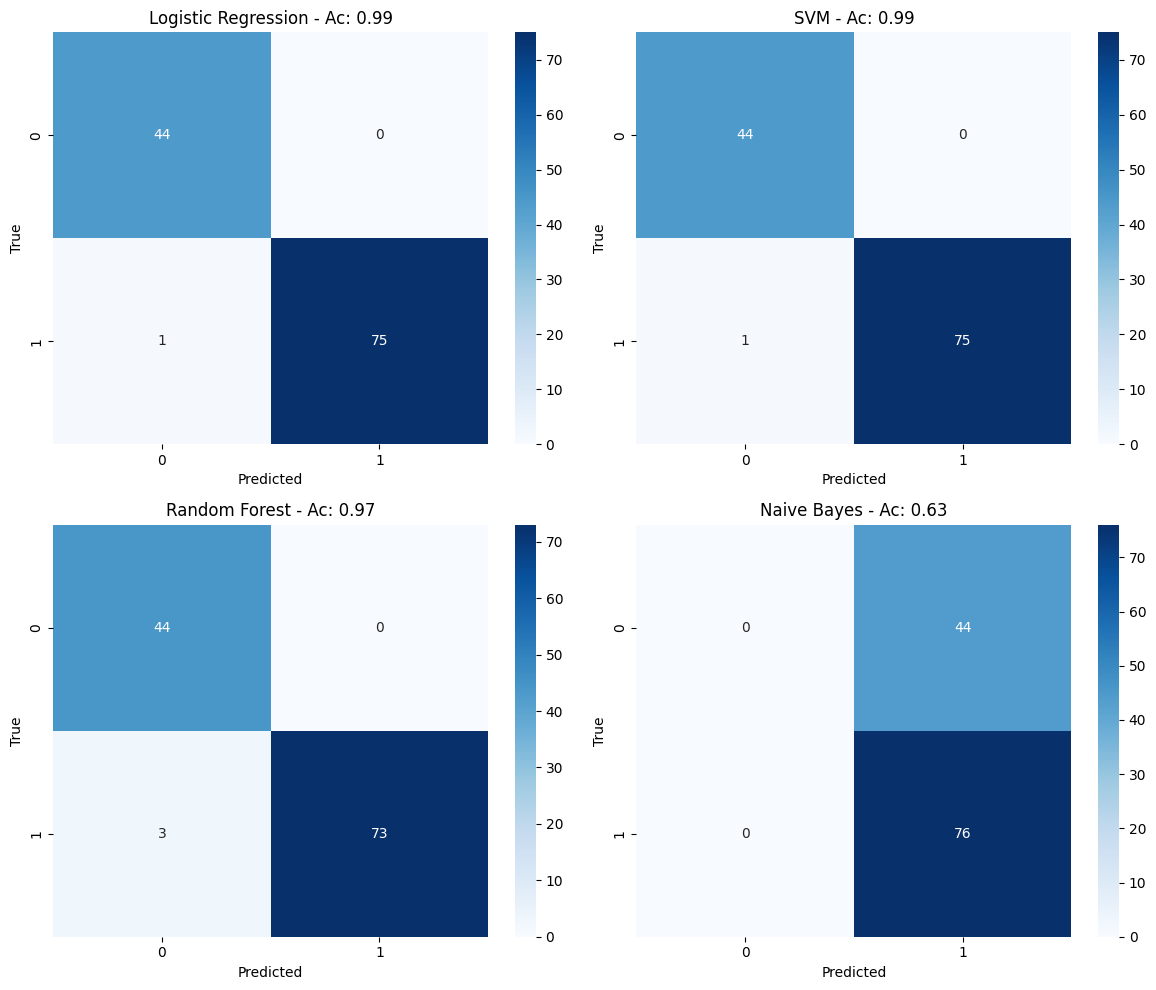

In [21]:
matrices = [conf_matrix_lr, conf_matrix_svm, conf_matrix_rf, conf_matrix_gnb]  # Replace with your confusion matrices
accuracies = [accuracy_lr, accuracy_svm, accuracy_rf, accuracy_gnb]
titles = ['Logistic Regression', 'SVM', 'Random Forest', 'Naive Bayes']

# Create a figure with a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easy iteration
axs = axs.flatten()


for ax, cm, title, accuracy in zip(axs, matrices, titles, accuracies):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{title} - Ac: {accuracy:.2f}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

## Show Confusion Matrix of Deep Learning Algorithms

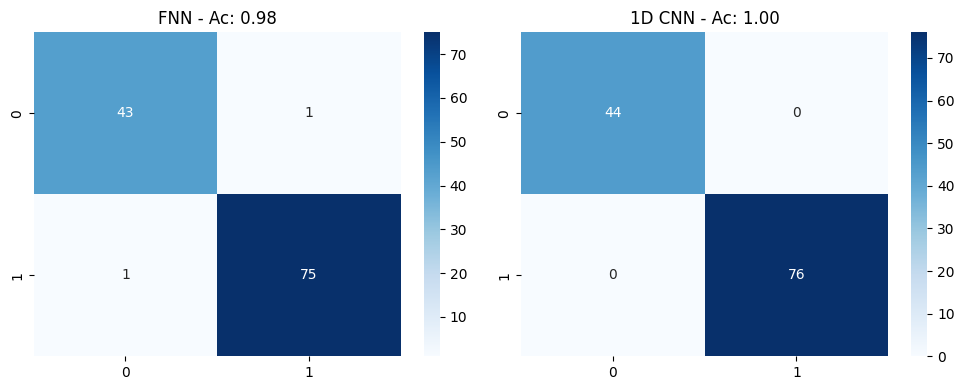

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

matrices = [conf_matrix_fnn, conf_matrix_cnn]  # Replace with your confusion matrices
accuracies = [accuracy_fnn, accuracy_cnn]
titles = ['FNN', '1D CNN']

for ax, cm, title,accuracy in zip(axs, matrices, titles, accuracies):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{title} - Ac: {accuracy:.2f}')

plt.tight_layout()
plt.show()

## Result Compresion Between All Featurs and Selected Features

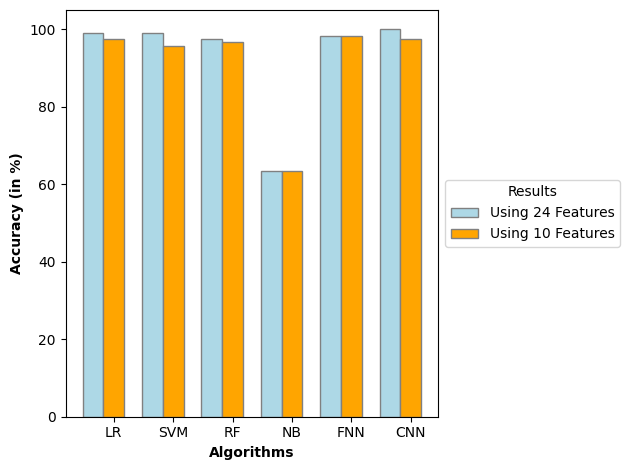

[99.16666666666667, 99.16666666666667, 97.5, 63.33333333333333, 98.33333333333333, 100.0] [97.5, 95.83333333333334, 96.66666666666667, 63.33333333333333, 98.33333333333333, 97.5]


In [23]:
# Data for the chart
algorithms = ['LR', 'SVM', 'RF', 'NB', 'FNN', 'CNN']
shade1 = [accuracy_lr*100, accuracy_svm*100, accuracy_rf*100, accuracy_gnb*100, accuracy_fnn*100, accuracy_cnn*100]
shade2 = [accuracy_lr_fs*100, accuracy_svm_fs*100, accuracy_rf_fs*100, accuracy_gnb_fs*100, accuracy_fnn_fs*100, accuracy_cnn_fs*100]

# Set the bar width
bar_width = 0.35

# Positions for each bar on the x-axis
r1 = np.arange(len(algorithms))
r2 = [x + bar_width for x in r1]

# Create the grouped bar chart
plt.bar(r1, shade1, color='lightblue', width=bar_width, edgecolor='grey', label='Using 24 Features')
plt.bar(r2, shade2, color='orange', width=bar_width, edgecolor='grey', label='Using 10 Features')

# Add labels
plt.xlabel('Algorithms', fontweight='bold')
plt.ylabel('Accuracy (in %)', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(algorithms))], algorithms)

# Move the legend to the right of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Results")

# Adjust the layout to make room for the legend
plt.tight_layout()

# Display the chart
plt.show()

print(shade1, shade2)

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

# Load the dataset (example: replace 'your_dataset.csv' with your file)
data = pd.read_csv('Crop_recommendation.csv')

# Step 1: Basic Data Exploration
print(data.head())
print(data.info())
print(data.describe())

# Step 2: Handle Missing Values
data.fillna(data.mean(), inplace=True)  # Replace numerical NaN values with mean

# Step 3: Encode Categorical Variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Step 4: Split Features and Target Variable
X = data.drop(columns=['target_column'])  # Replace 'target_column' with your target variable name
y = data['target_column']

# Step 5: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Feature Scaling (for models like SVM and Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Apply and Evaluate Different Models

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
log_accuracy = accuracy_score(y_test, y_pred_log)
print("Logistic Regression Accuracy:", log_accuracy)

# Linear Regression (for regression problems only)
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lin = lin_reg.predict(X_test_scaled)
lin_mse = mean_squared_error(y_test, y_pred_lin)
print("Linear Regression MSE:", lin_mse)

# SVM (Support Vector Machine)
svm = SVC()
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", svm_accuracy)

# Decision Tree
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X_train, y_train)
y_pred_tree = dec_tree.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print("Decision Tree Accuracy:", tree_accuracy)

# Compare Results
print("\nModel Comparison:")
print(f"Logistic Regression Accuracy: {log_accuracy}")
print(f"SVM Accuracy: {svm_accuracy}")
print(f"Decision Tree Accuracy: {tree_accuracy}")
if 'lin_mse' in locals():
    print(f"Linear Regression MSE: {lin_mse}")


    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None
         

TypeError: Could not convert ['ricericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericericemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizemaizechickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeachickpeakidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanskidneybeanspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeaspigeonpeasmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmothbeansmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanmungbeanblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramblackgramlentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentillentilpomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatepomegranatebananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananabananamangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangomangograpesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapesgrapeswatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonwatermelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonmuskmelonappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleappleorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangeorangepapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayapapayacoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcoconutcottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottoncottonjutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutejutecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffeecoffee'] to numeric